In [1]:
# Get GPU name
# !nvidia-smi -L

In [2]:
# Get helper functions
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

--2024-09-07 14:59:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-09-07 14:59:33 (115 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Get Food101 Dataset
import tensorflow_datasets as tfds

datasets_list = tfds.list_builders()
target_dataset = "food101"

(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.TD90DI_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.TD90DI_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [4]:
  # Get class name of Food101
class_names = ds_info.features["label"].names
# class_names[:10]

In [5]:
# train_one_sample = train_data.take(1)

# for image, label in train_one_sample:
#   print(f"""
#   Image shape: {image.shape}
#   Image dtype: {image.dtype}
#   Target class from Food101 (tensor form): {label}
#   Class name (str form): {class_names[label.numpy()]}
#         """)

In [6]:
# Get the true class labels from the test_data
y_labels = []

for image, label in test_data:
    y_labels.append(label.numpy())

# print(y_labels)

In [7]:
import tensorflow as tf

# tf.reduce_min(image), tf.reduce_max(image)

In [8]:
import matplotlib.pyplot as plt

# plt.imshow(image)
# plt.title(class_names[label.numpy()])
# plt.axis(False)

In [9]:
# Preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(image, tf.float32), label

In [10]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [11]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [12]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy(policy="mixed_float16")
# mixed_precision.global_policy()

In [13]:
# Build feature extraction model
from tensorflow.keras import layers

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)

outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [15]:
tf.get_logger().setLevel('ERROR') # Turn off all warnings except for errors

history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[model_checkpoint])

Epoch 1/3
2368/2368 [==============================] - 64s 23ms/step - loss: 1.7130 - accuracy: 0.5825 - val_loss: 1.1249 - val_accuracy: 0.6947
Epoch 2/3
2368/2368 [==============================] - 52s 22ms/step - loss: 1.1991 - accuracy: 0.6888 - val_loss: 1.0233 - val_accuracy: 0.7153
Epoch 3/3
2368/2368 [==============================] - 52s 22ms/step - loss: 1.0548 - accuracy: 0.7235 - val_loss: 0.9881 - val_accuracy: 0.7283


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [17]:
# Evaluate model
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 12s 15ms/step - loss: 0.9948 - accuracy: 0.7299


[0.9948081970214844, 0.7299405932426453]

In [18]:
# Build Fine-tuning model on feature extraction model
for layer in model.layers:
    layer.trainable = True
    # print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

In [19]:
# Setup EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

# Create ModelCheckpoint callback
checkpoint_path = "fine_tune_checkpoints.keras"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [20]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [21]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])

In [22]:
history_101_food_classes_all_data_fine_tune = model.fit(train_data,
                                                        epochs=100,
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)),
                                                        callbacks=[model_checkpoint,
                                                                   early_stopping,
                                                                   reduce_lr])

Epoch 1/100
2368/2368 [==============================] - 184s 63ms/step - loss: 0.8688 - accuracy: 0.7647 - val_loss: 0.7616 - val_accuracy: 0.7871 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 148s 62ms/step - loss: 0.5370 - accuracy: 0.8504 - val_loss: 0.7232 - val_accuracy: 0.7998 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 146s 61ms/step - loss: 0.3012 - accuracy: 0.9135 - val_loss: 0.7975 - val_accuracy: 0.7937 - lr: 1.0000e-04
Epoch 4/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.1589 - accuracy: 0.9534
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 146s 61ms/step - loss: 0.1589 - accuracy: 0.9534 - val_loss: 0.8920 - val_accuracy: 0.7942 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 146s 61ms/step - loss: 0.0331 - accuracy: 0.9924 - val_loss: 1.0007 - val_accuracy: 0.8093 - lr: 2.0000e-05


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [24]:
# Evaluate model
results_fine_tuning_model = model.evaluate(test_data)
results_fine_tuning_model

790/790 [==============================] - 12s 15ms/step - loss: 1.0191 - accuracy: 0.8048


[1.0191094875335693, 0.8047921061515808]

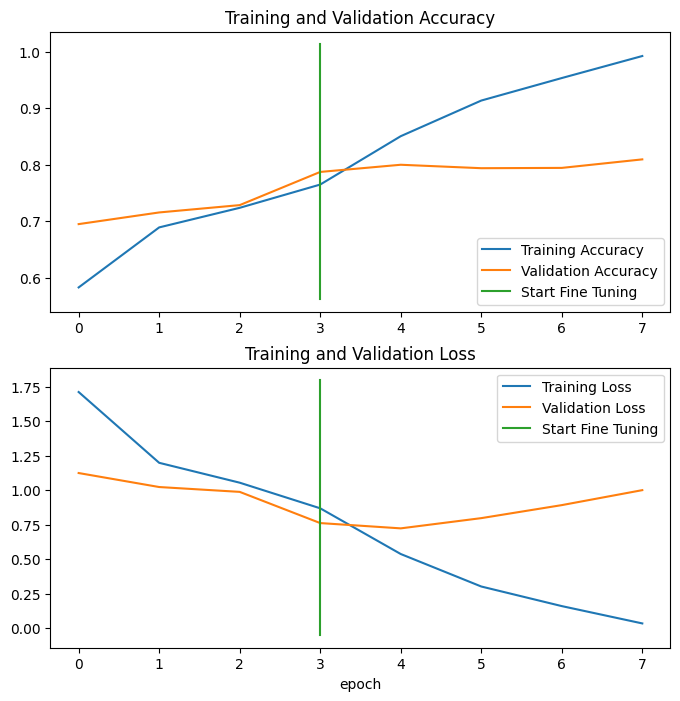

In [25]:
compare_historys(original_history=history_101_food_classes_feature_extract,
                 new_history=history_101_food_classes_all_data_fine_tune,
                 initial_epochs=4)

In [26]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 12s 13ms/step


In [27]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes

array([ 82, 100,  79, ...,  81,  23,  32])

In [31]:
# Test out the model on custom image
def load_and_prep_image(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

In [34]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

import zipfile

zip_ref = zipfile.ZipFile("custom_food_images.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-09-07 15:38:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.2’

custom_food_images. 100%[===================>]  12.58M  7.11MB/s    in 1.8s    

2024-09-07 15:38:18 (7.11 MB/s) - ‘custom_food_images.zip.2’ saved [13192985/13192985]



In [35]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
# custom_food_images

1/1 [==============================] - 0s 28ms/step


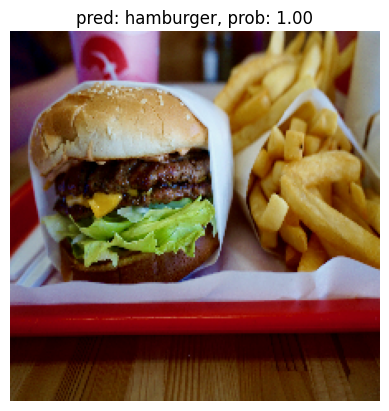

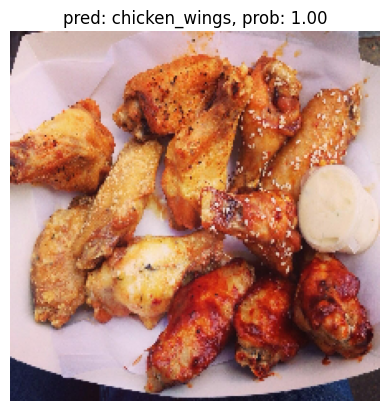

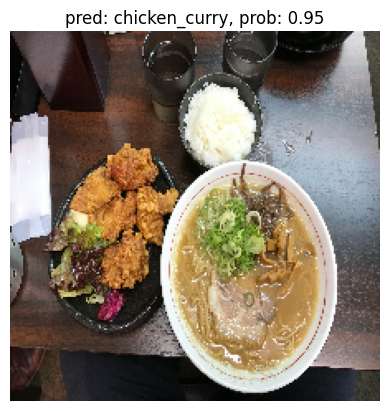

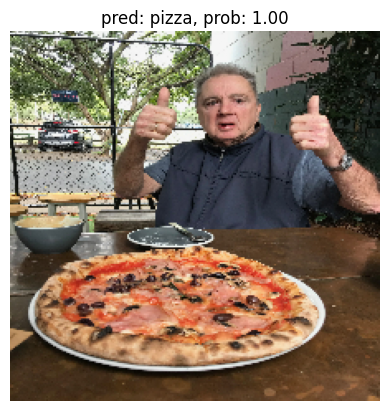

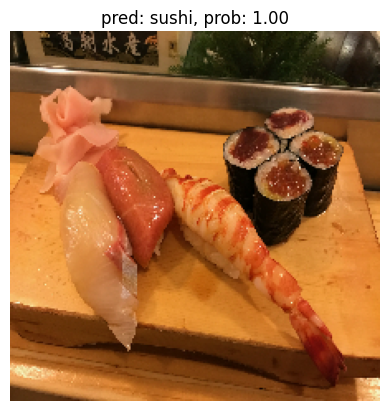

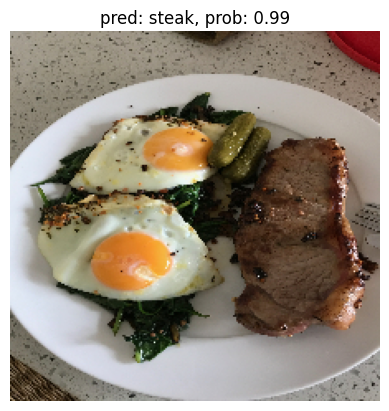

In [36]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

In [37]:
# Save model
model.save("101Food-Vision-Model")